<a href="https://isaic.ece.ualberta.ca/"> <center><img src="img/index.png" alt="Header" style="width: 200px;"/></center> </a>

> # cuDF : Python GPU DataFrame Library
>
> **Presentor:** Industry Sandbox and AI Computing (ISAIC)
>
> **Date:** 

## What is DataFrame and why use it?

DataFrame is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table, or a dict of Series objects.

For any machine learning (ML) problem, we need structured datasets to use as input for the ML model. DataFrame provides the efficient way of handling any processing of large volume data (such as linear operations, reduced operations, removing/replacing missing values etc.).

Pandas ([link](https://pandas.pydata.org/docs/user_guide/index.html#user-guide)) is the standard Python library to load datasets in form of DataFrames. However, Pandas works only on CPUs. To accelerate DataFrame operations on GPUs, cuDF ([link](https://docs.rapids.ai/api/cudf/stable/)) provides the very similar libraries like Pandas, but for GPUs.

Any cuDF dataframe operation works on single GPU and suitable for use as long as the dataset fits in the GPU memory. However, if one wants to distribute the dataframe workflow on multiple GPUs, cuDF provides an additional library called Dask-cuDF to make the workflow distributed in parallel over multiple GPUs.


In [10]:
#Load necessary python modules
import os
import numpy as np
import cupy as cp
import pandas as pd
import cudf
import dask_cudf

import geopandas
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure', dpi=250)
from glob import glob


### Check the GPUs available

In [11]:
!nvidia-smi

Tue Apr  5 20:20:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   32C    P0    35W / 250W |    679MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:00:07.0 Off |                    0 |
| N/A   

## Example Dataset for this tutorial:

We need an example dataset for this tutorial that is large enough to make fair comparisons between pandas operation on CPU and cuDF operations on GPU. We choose the opensource air traffic data from OpenSky Network 2020. The dataset gives 3-year air traffic data (2019, 2020, 2021) to study the impact of COVID-19 pandemic on air travel. The 3-year dataset has over 6GB of size.

### Description of the dataset

One file per month is provided as a csv file with the following features:

- **callsign:** the identifier of the flight displayed on ATC screens (usually the first three letters are reserved for an airline: AFR for Air France, DLH for Lufthansa, etc.)
- **number:** the commercial number of the flight, when available (the matching with the callsign comes from public open API)
- icao24: the transponder unique identification number;
- registration: the aircraft tail number (when available);
- typecode: the aircraft model type (when available);
- **origin:** a four letter code for the origin airport of the flight (when available);
- **destination:** a four letter code for the destination airport of the flight (when available);
- **firstseen:** the UTC timestamp of the first message received by the OpenSky Network;
- **lastseen:** the UTC timestamp of the last message received by the OpenSky Network;
- **day:** the UTC day of the last message received by the OpenSky Network;
- **latitude_1, longitude_1, altitude_1:** the first detected position of the aircraft;
- **latitude_2, longitude_2, altitude_2:** the last detected position of the aircraft.


## Functions to load datasets

In [12]:
#list of years
year = ['2019', '2020', '2021']

#function to load pandas data frame
def load_pandas(year):
    print (f"Loading {year} dataset...")
    filenames = sorted(glob('dataset/'+year+'/*.csv.gz'))
    df_holder = []
    for f in filenames:
        df_holder.append(pd.read_csv(f))
    return pd.concat(df_holder)

#function to load dataset as cudf dataframe
def load_cudf(year):
    print (f"Loading {year} dataset...")
    filenames = sorted(glob('dataset/'+year+'/*.csv.gz'))
    df_holder = []
    for f in filenames:
        df_holder.append(cudf.read_csv(f))
    return cudf.concat(df_holder)

#function to load dataset as dask_cudf dataframe
def load_dask_cudf(year):
    ddf = dask_cudf.read_csv('dataset/'+year+'/*.csv.gz', npartitions=2)
    return ddf



# Benchmarking dataset loading times

In [14]:
%%time
#1. Pandas dataframe loading
pd2019 = load_pandas('2019')

Loading 2019 dataset...


<timed exec>:2: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 2min 24s, sys: 13.6 s, total: 2min 38s
Wall time: 2min 38s


In [15]:
%%time
#2. cuDF dataframe loading
cudf2019 = load_cudf('2019')


Loading 2019 dataset...
CPU times: user 32.3 s, sys: 3.88 s, total: 36.2 s
Wall time: 36.2 s


In [7]:
%%time
#3. Dask-cuDF dataframe loading
dcdf2019 = load_dask_cudf('2019')

/opt/tljh/user/lib/python3.9/site-packages/dask_cudf/io/csv.py:102: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``chunksize=None to remove this message``
Setting ``chunksize=(size of file)``
  warn(


CPU times: user 2.12 s, sys: 308 ms, total: 2.43 s
Wall time: 2.43 s


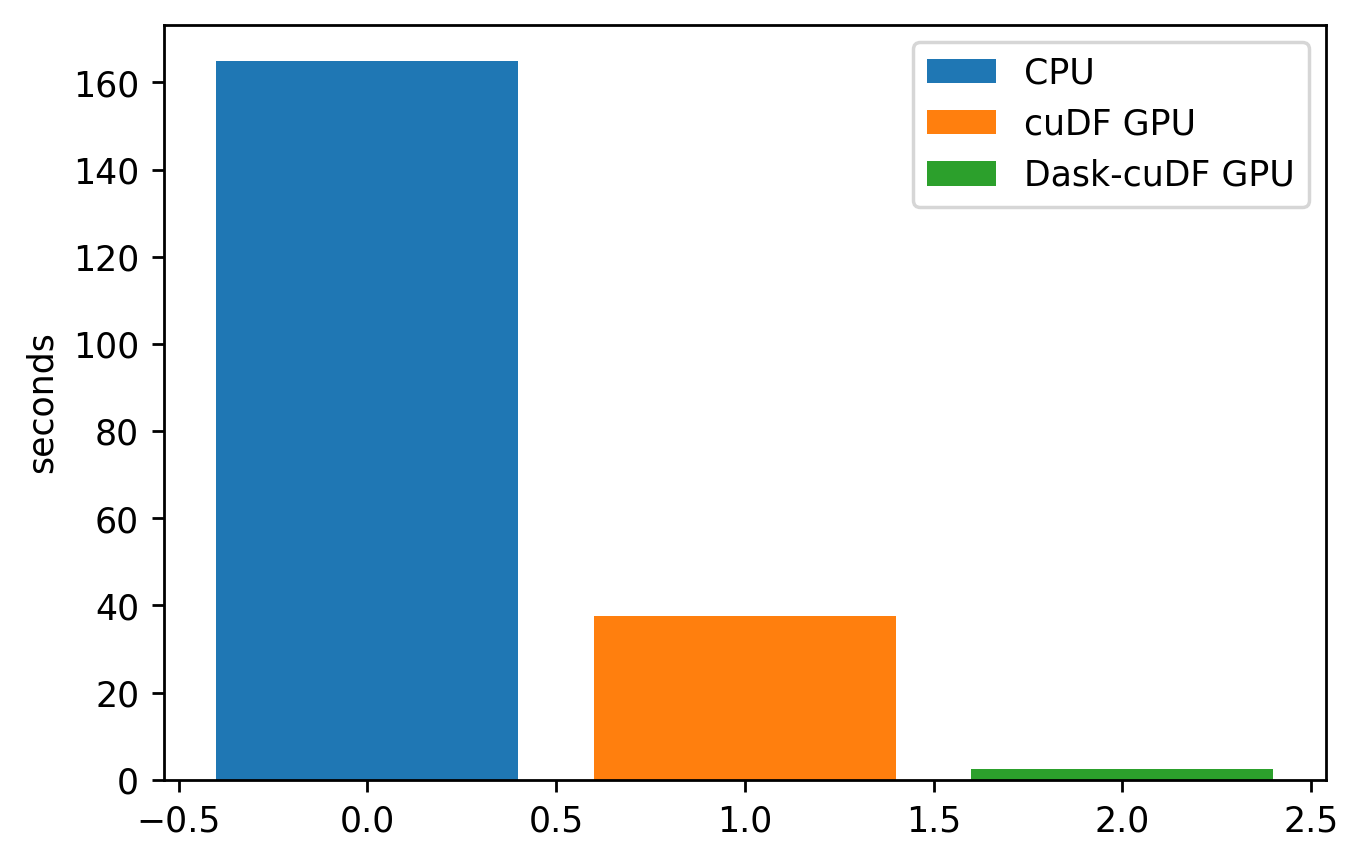

In [15]:
#comparing the loading time
plt.figure()
plt.bar([0], [165.], label='CPU')
plt.bar([1], [37.5], label='cuDF GPU' )
plt.bar([2], [2.43], label='Dask-cuDF GPU')
plt.legend()
plt.ylabel('seconds')
plt.show()

## Benchmarking the processing times

In [19]:
#let's check out the content of data first
cudf2019.head(10)

,callsign,number,icao24,registration,typecode,origin,destination,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2
0,HVN19,<NA>,888152,<NA>,<NA>,YMML,LFPG,2018-12-31 00:43:16+00:00,2019-01-01 04:56:29+00:00,2019-01-01 00:00:00+00:00,-37.659485,144.804421,304.8,48.995316,2.610802,-53.34
1,CCA839,<NA>,780ad1,<NA>,<NA>,YMML,LEBL,2018-12-31 00:53:08+00:00,2019-01-01 06:01:42+00:00,2019-01-01 00:00:00+00:00,-37.692123,144.841997,304.8,41.036124,2.063557,1112.52
2,CES219,<NA>,780b7e,B-5936,A332,YSSY,EDDF,2018-12-31 01:05:29+00:00,2019-01-01 04:09:29+00:00,2019-01-01 00:00:00+00:00,-33.930908,151.171987,0.0,50.045563,8.588923,-15.24
3,AEA040,<NA>,34444e,EC-LVL,A332,LEMD,LEMD,2018-12-31 01:07:21+00:00,2019-01-01 03:32:59+00:00,2019-01-01 00:00:00+00:00,40.534756,-3.575426,609.6,40.475728,-3.538347,411.48
4,CXA825,<NA>,780d75,B-2760,B788,YSSY,LFPG,2018-12-31 01:18:29+00:00,2019-01-01 04:32:28+00:00,2019-01-01 00:00:00+00:00,-33.954254,151.178041,0.0,48.996091,2.625805,22.86
5,TGW700,<NA>,76bcca,9V-OFJ,B788,<NA>,RJBB,2018-12-31 01:30:50+00:00,2019-01-01 08:19:13+00:00,2019-01-01 00:00:00+00:00,34.641243,140.942345,8534.4,34.449354,135.237179,-99.06
6,CLU211,<NA>,406ea3,G-CLAA,B744,UUEE,EDDF,2018-12-31 01:49:28+00:00,2019-01-01 04:11:38+00:00,2019-01-01 00:00:00+00:00,55.967560,37.371327,304.8,50.044400,8.583737,-30.48
7,CSN609,<NA>,781364,<NA>,<NA>,<NA>,KLAX,2018-12-31 02:28:27+00:00,2019-01-01 04:53:37+00:00,2019-01-01 00:00:00+00:00,37.042923,114.838685,10972.8,33.952057,-118.383627,129.54
8,CSN679,<NA>,780db0,B-5967,A333,<NA>,LTBA,2018-12-31 03:08:15+00:00,2019-01-01 02:09:11+00:00,2019-01-01 00:00:00+00:00,37.002884,114.842715,10972.8,40.804184,28.714478,2011.68
9,ETH704,<NA>,04004b,ET-AOU,B788,KLDJ,LFPG,2018-12-31 03:31:48+00:00,2019-01-01 04:30:10+00:00,2019-01-01 00:00:00+00:00,40.584567,-74.228314,609.6,48.996002,2.623408,0.00


## Visualizing the flight start positions

CPU times: user 7.34 s, sys: 679 ms, total: 8.01 s
Wall time: 7.88 s


(-198.0, 198.00000000000006, -98.6822565, 92.3273865)

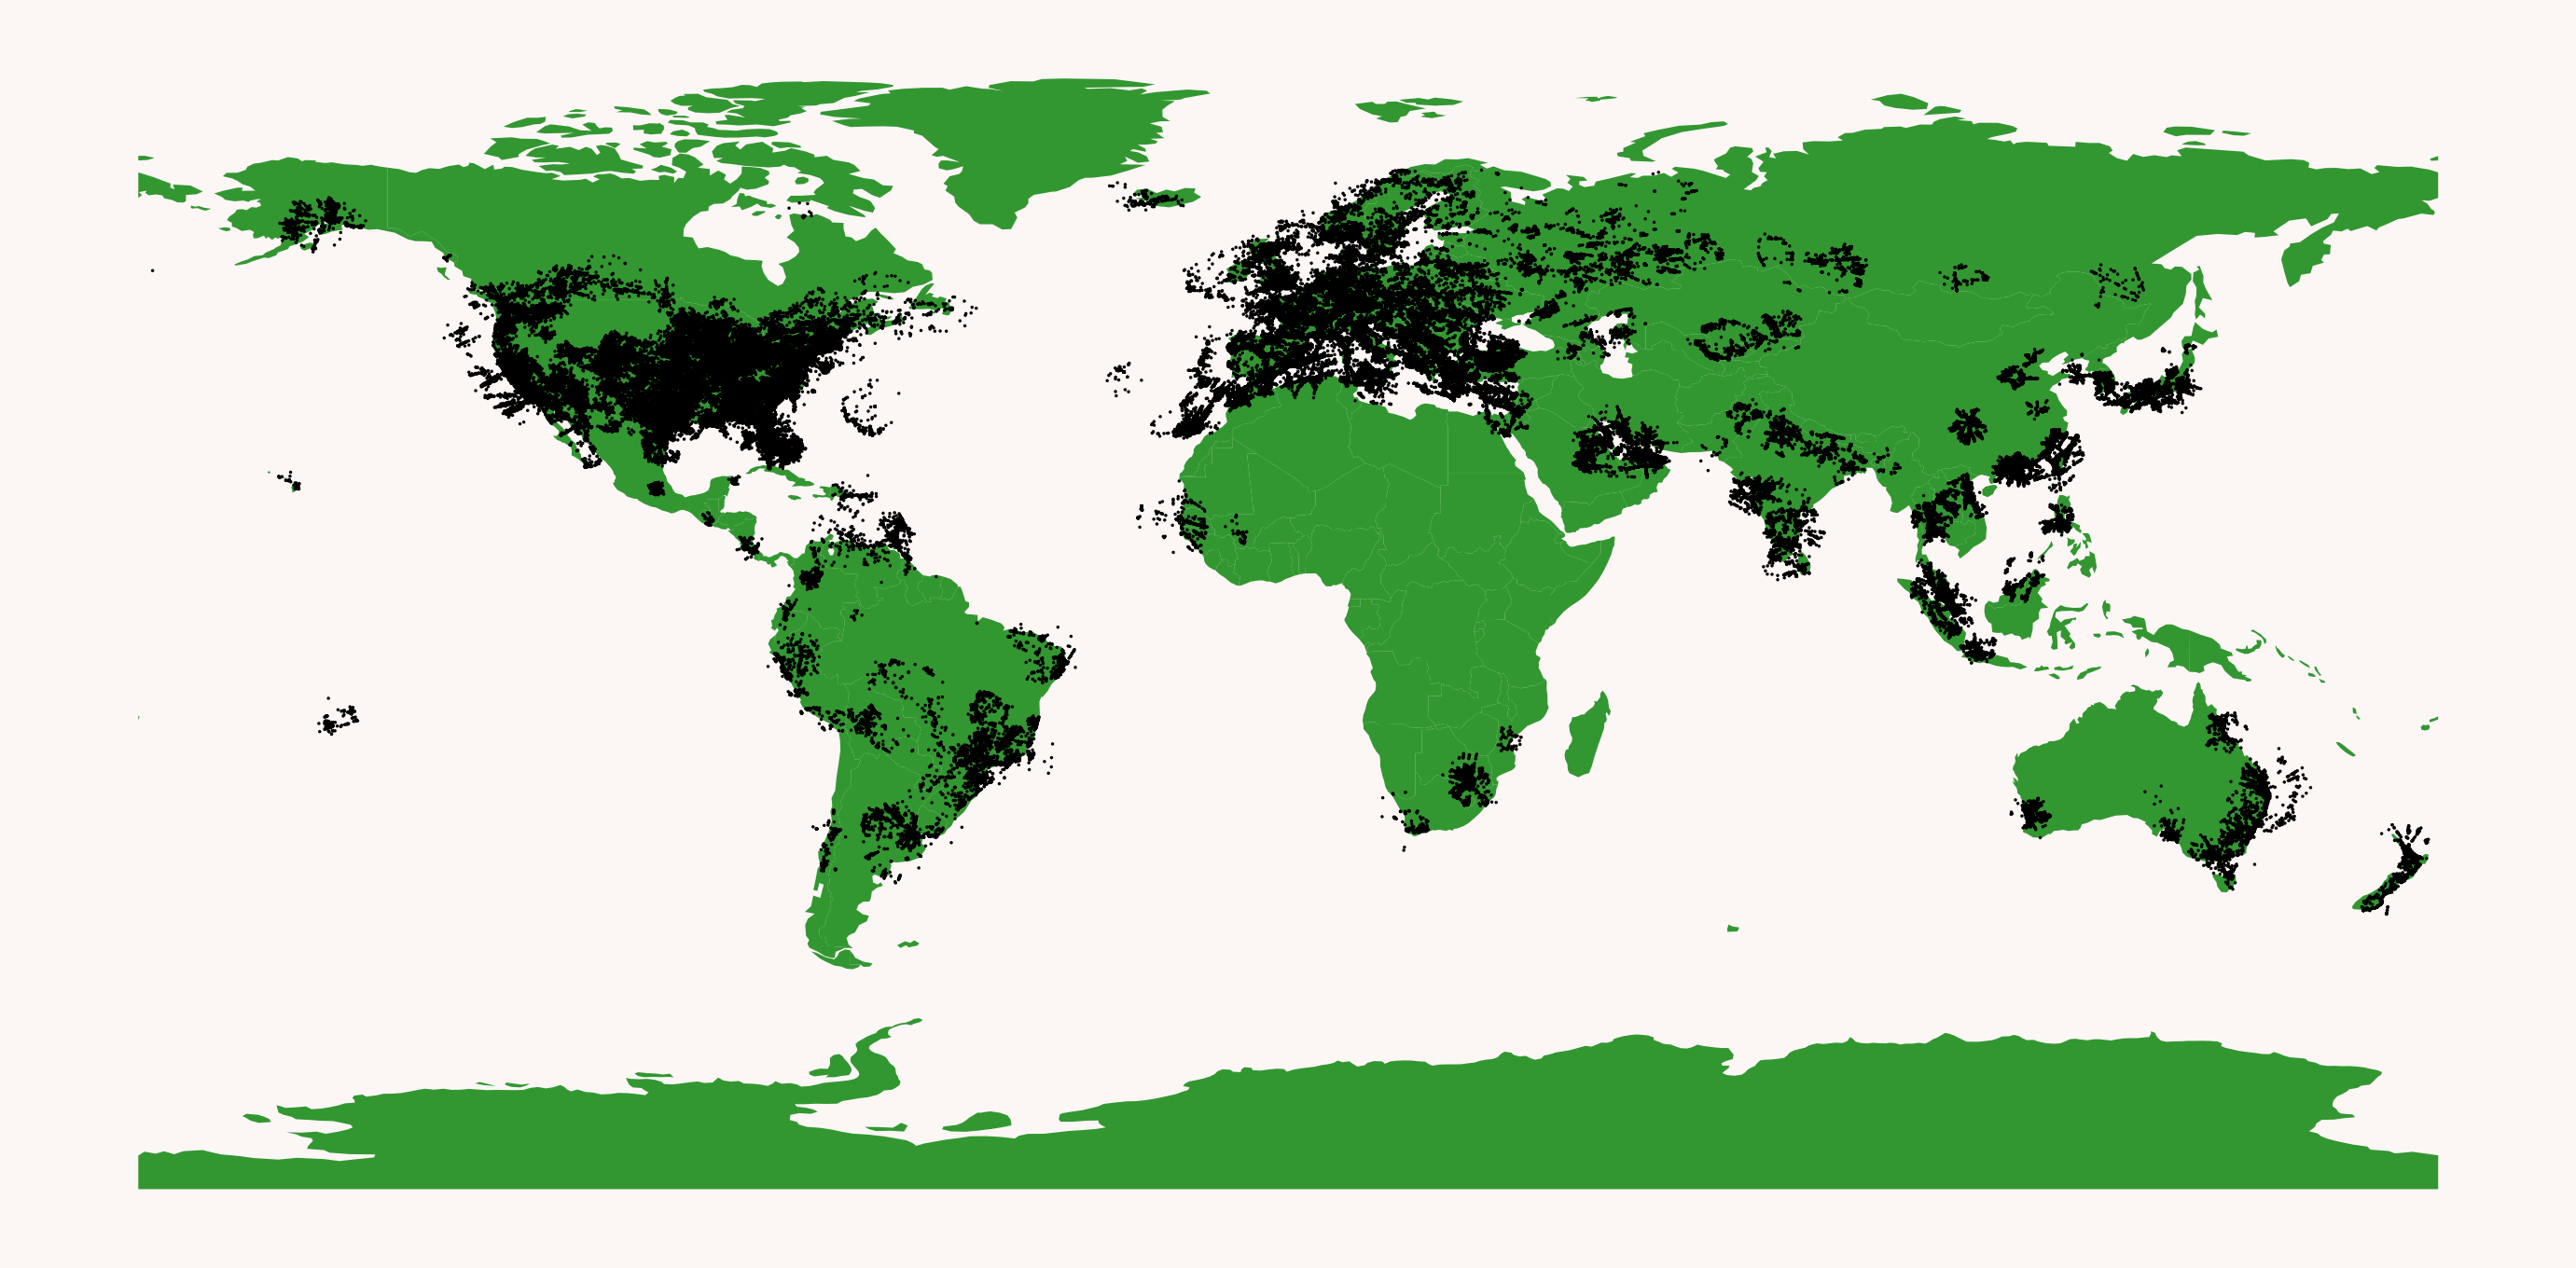

In [27]:
%%time
#getting the list of unique flights
unique_flights = pd2019.drop_duplicates(subset=['callsign'])

#checking for missing values
#unique_flights.callsign.isna().unique()

#dropping any missing values if exists
unique_flights.callsign.dropna()

#selecting the specific columns
flight_paths = unique_flights[['latitude_1', 'longitude_1', 'latitude_2', 'longitude_2']]

#converting the start positions to numpy arrays
start = [flight_paths['longitude_1'].to_numpy(), flight_paths['latitude_1'].to_numpy()]

#load the base world map layout
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(14, 7)
world.plot(ax=ax, color='g', alpha=0.8)
#plot the start posuitionds
ax.scatter(x=start[0], y=start[1],
           s=1, alpha=1, edgecolors='none', color='k')
#ax.plot(start, end, lw=1, alpha=0.3)
ax.axis('off')


- **Panadas on CPU : 7.88s**

CPU times: user 1.19 s, sys: 83.7 ms, total: 1.27 s
Wall time: 1.14 s


(-198.0, 198.00000000000006, -98.6822565, 92.3273865)

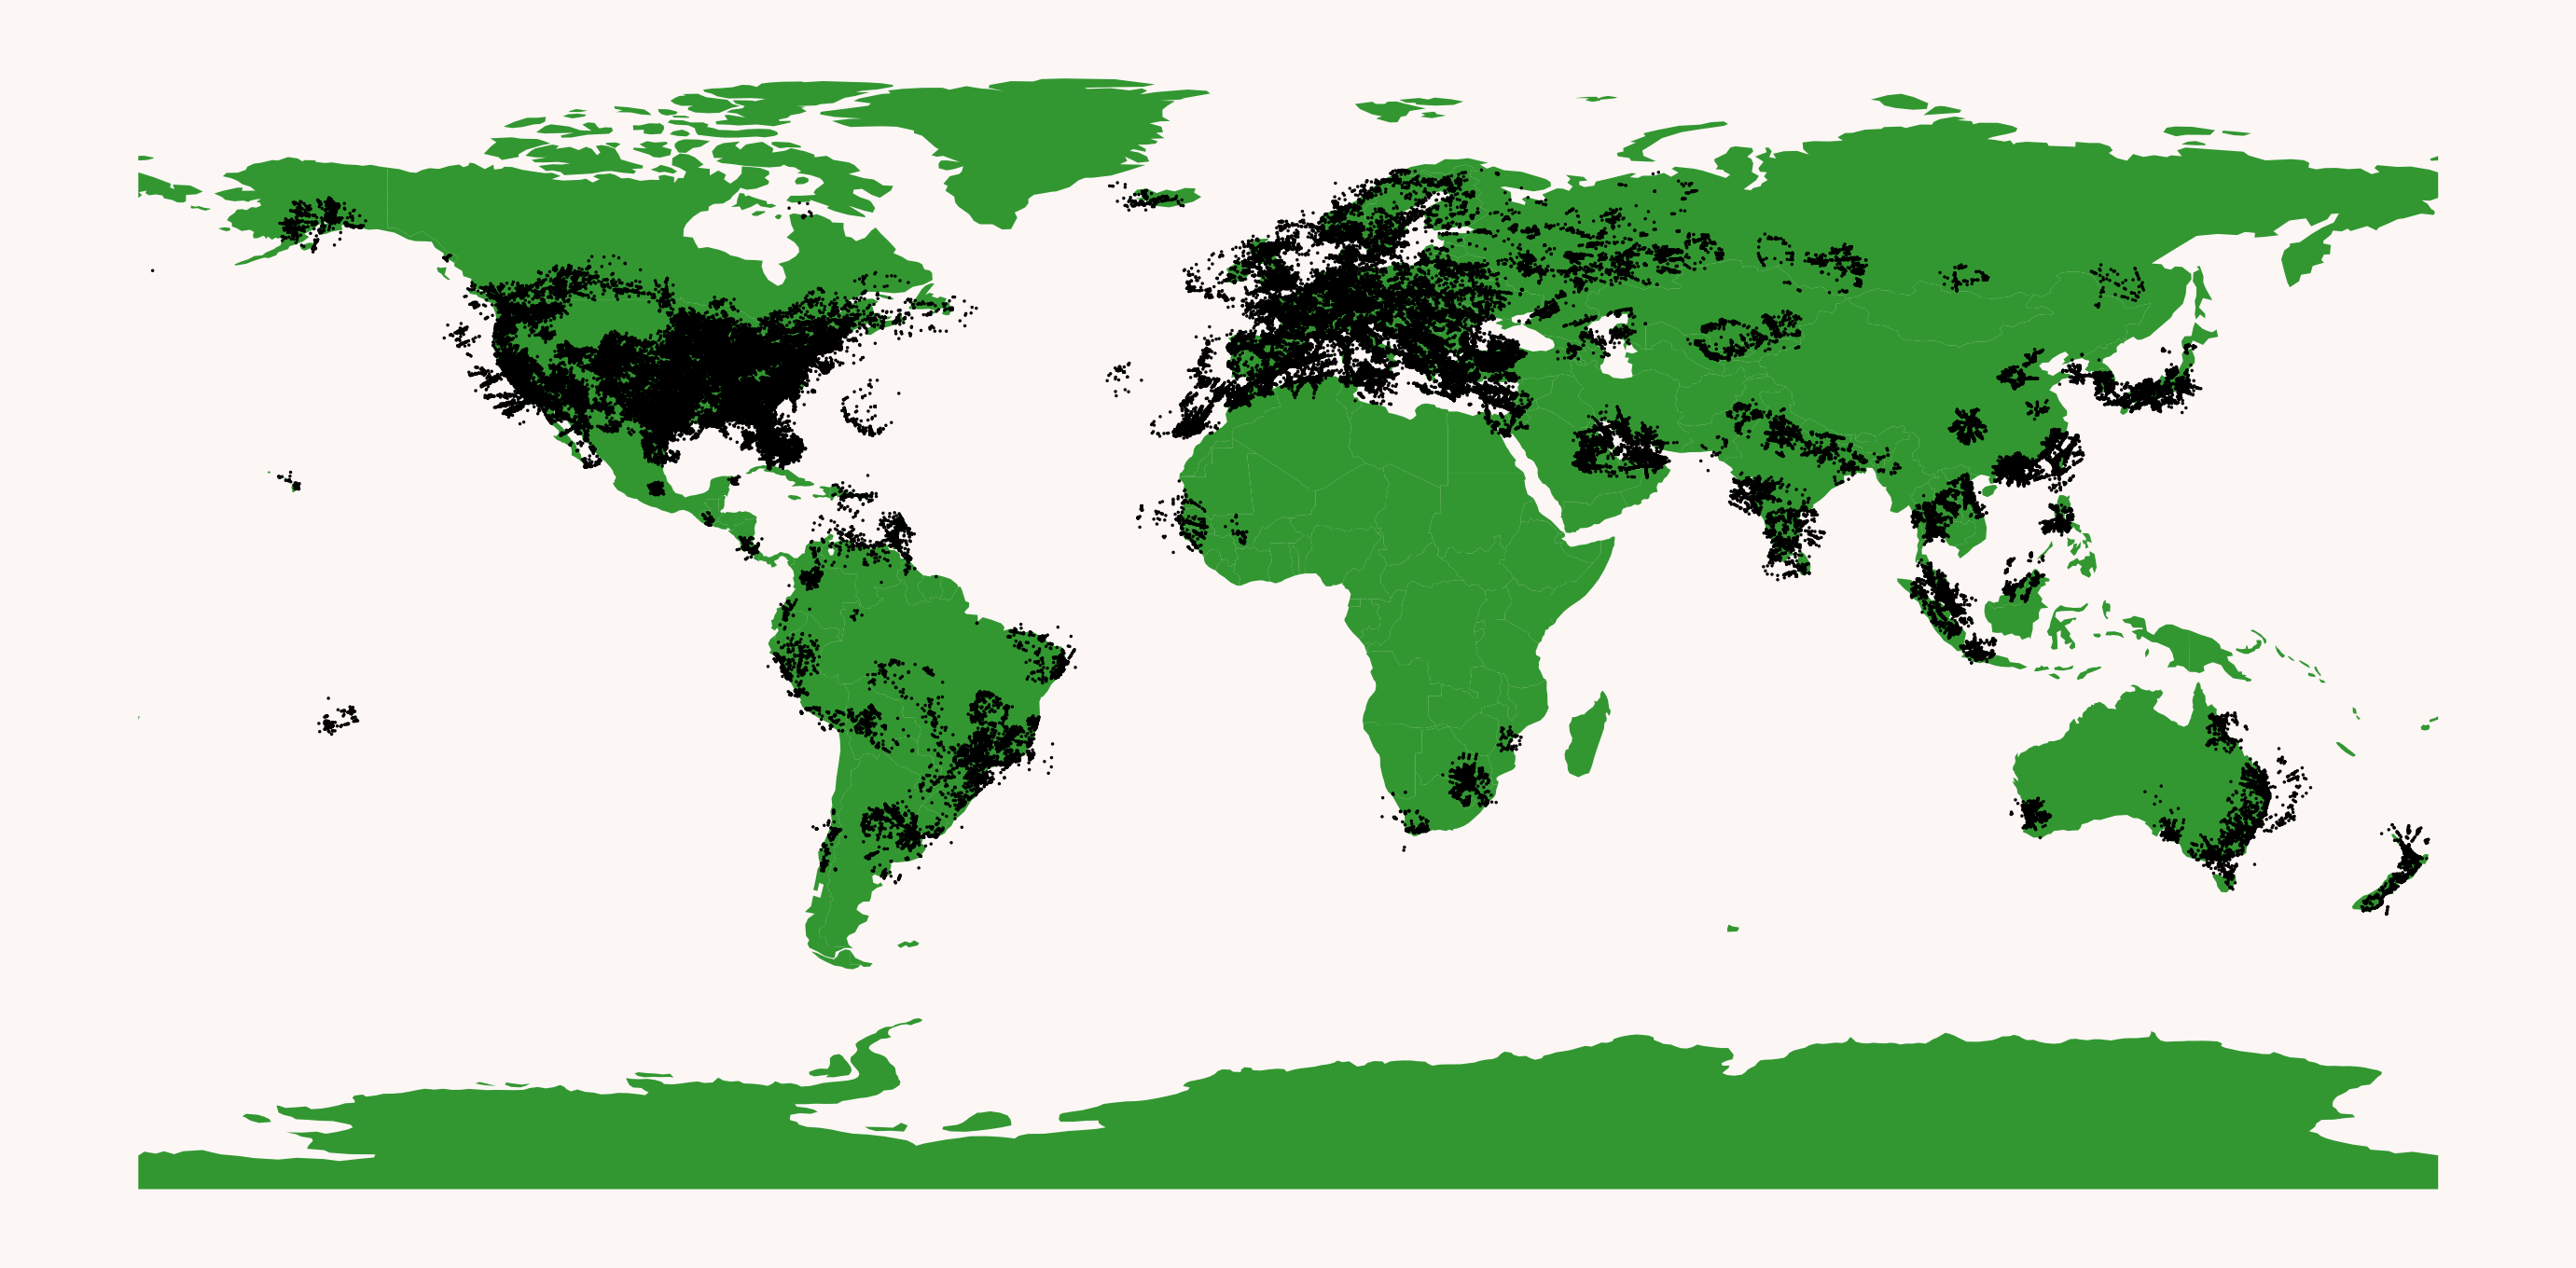

In [28]:
%%time
#getting the list of unique flights
unique_flights = cudf2019.drop_duplicates(subset=['callsign'])
#checking 
#unique_flights.callsign.isna().unique()
unique_flights.callsign.dropna()
flight_paths = unique_flights[['latitude_1', 'longitude_1', 'latitude_2', 'longitude_2']]

start = [flight_paths['longitude_1'].to_numpy(), flight_paths['latitude_1'].to_numpy()]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(14, 7)
world.plot(ax=ax, color='g', alpha=0.8)
ax.scatter(x=start[0], y=start[1],
           s=1, alpha=1, edgecolors='none', color='k')
#ax.plot(start, end, lw=1, alpha=0.3)
ax.axis('off')


- **cuDF on GPU : 1.14s**

CPU times: user 33.7 s, sys: 4.36 s, total: 38.1 s
Wall time: 38 s


(-198.0, 198.00000000000006, -103.32612986144076, 92.54852332673528)

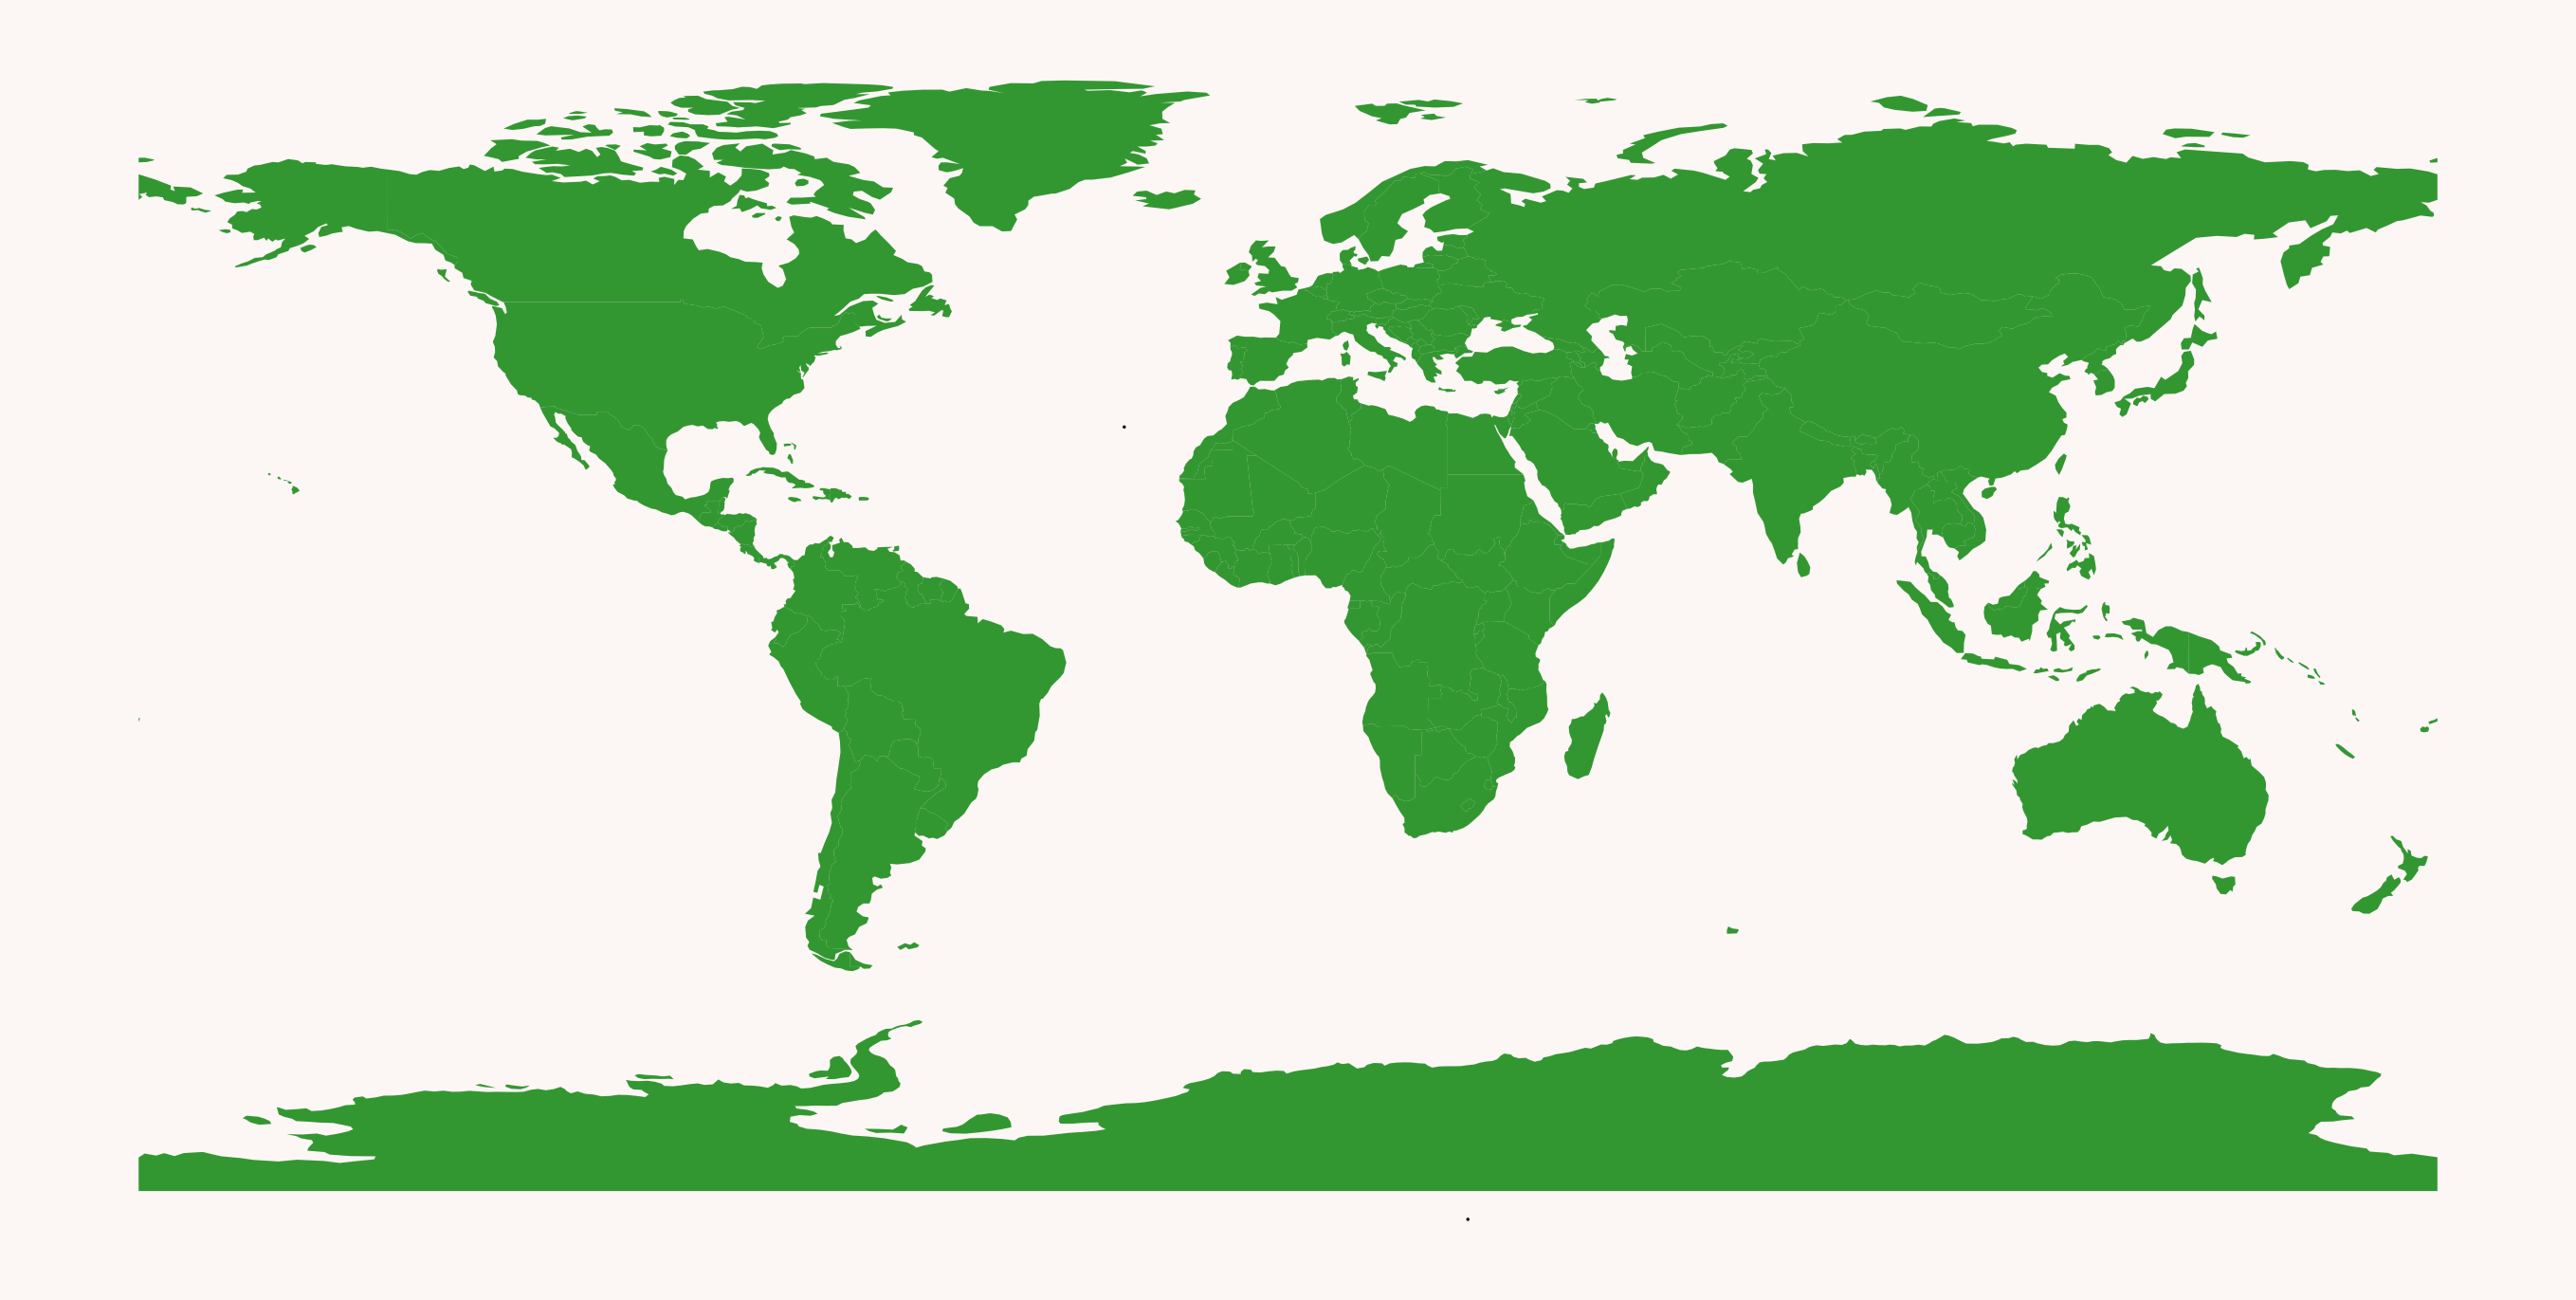

In [30]:
%%time
#getting the list of unique flights
unique_flights = dcdf2019.drop_duplicates(subset=['callsign'])
#checking 
#unique_flights.callsign.isna().unique()
unique_flights.callsign.dropna()
flight_paths = unique_flights[['latitude_1', 'longitude_1', 'latitude_2', 'longitude_2']]

#start = [flight_paths['longitude_1'].compute().to_numpy(), flight_paths['latitude_1'].compute().to_numpy()]

start = flight_paths[['longitude_1', 'latitude_1']].compute().to_numpy()
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(14, 7)
world.plot(ax=ax, color='g', alpha=0.8)
ax.scatter(x=start[0], y=start[1],
           s=1, alpha=1, edgecolors='none', color='k')
#ax.plot(start, end, lw=1, alpha=0.3)
ax.axis('off')


- **Dask-cuDF GPU: 38s**

The reason Dask-cuDF takes much longer than CPU or cuDF GPU is that Dask-cuDF form of DataFrames are distributed among multiple GPUs. When we call those dataframes to gather some results, it first converts the distributed dataframes into single-GPU cuDF dataframe. The cuDF dataframe is further sent to CPU to be accessed. For this reason, Dask-cuDF is not very efficient in performing small and simple operations and only be used when there is a long workflow of data processing to be done on large volume data. For this reason, we will not include Dask-cuDF comparisons in the later part of the tutorial.

### How many flights fly each day?

We can count the number of flights each day by counting the values for each day.

In [13]:
#function to calculate number of flights per day (dask_cudf)
def flights_per_day_df(df):
    return df.day.value_counts().sort_index().to_numpy()

In [35]:
%%time
#1. Pandas-CPU
num_2019 = flights_per_day_df(pd2019)

CPU times: user 1.94 s, sys: 12 ms, total: 1.96 s
Wall time: 1.94 s


In [36]:
%%time
#2. cuDF-GPU
num_2019 = flights_per_day_df(cudf2019)

CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 1.49 s


## Loading all three years and plotting daily flight patterns

- **Using Pandas on CPU**

Loading 2019 dataset...


<timed exec>:4: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.


Loading 2020 dataset...
Loading 2021 dataset...


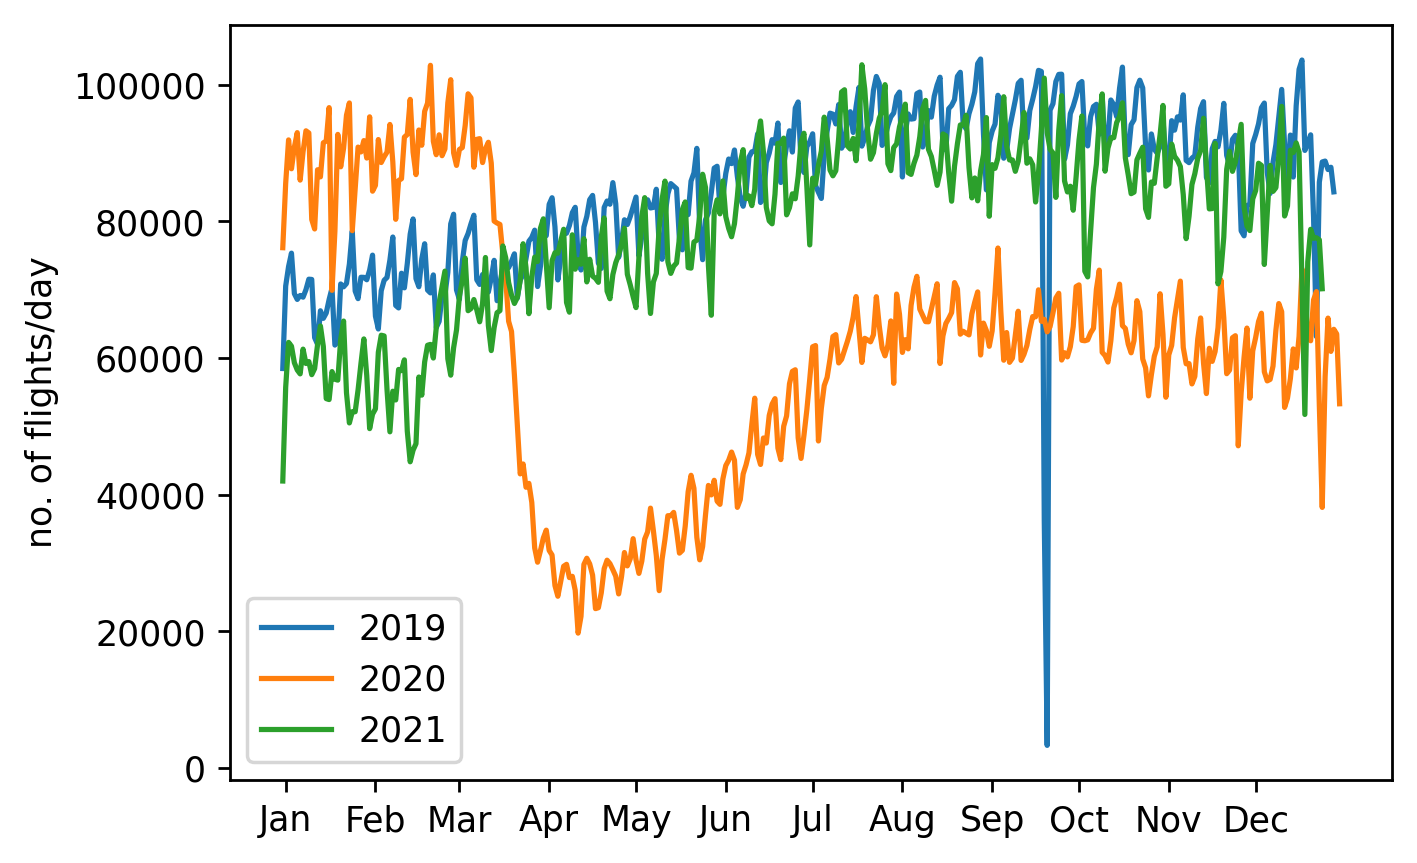

CPU times: user 6min 42s, sys: 38.9 s, total: 7min 21s
Wall time: 7min 20s


In [33]:
%%time
num_flights=[]

for y in year:
    df = load_pandas(y)
    num_flights.append(flights_per_day_df(df))
    del df

fig, ax = plt.subplots()
for i,data in enumerate(num_flights):
    ax.plot(data, label=year[i])
#ax.plot(num2020, label='2020')
#ax.plot(num2021, label='2021')
month_starts = [1,32,61,92,122,153,183,214,245,275,306,336]
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec'] 

ax.set_xticks(month_starts)
ax.set_xticklabels(month_names)
plt.legend()
plt.ylabel('no. of flights/day')
plt.show()

- **Using cuDF on GPU**

Loading 2019 dataset...
Loading 2020 dataset...
Loading 2021 dataset...


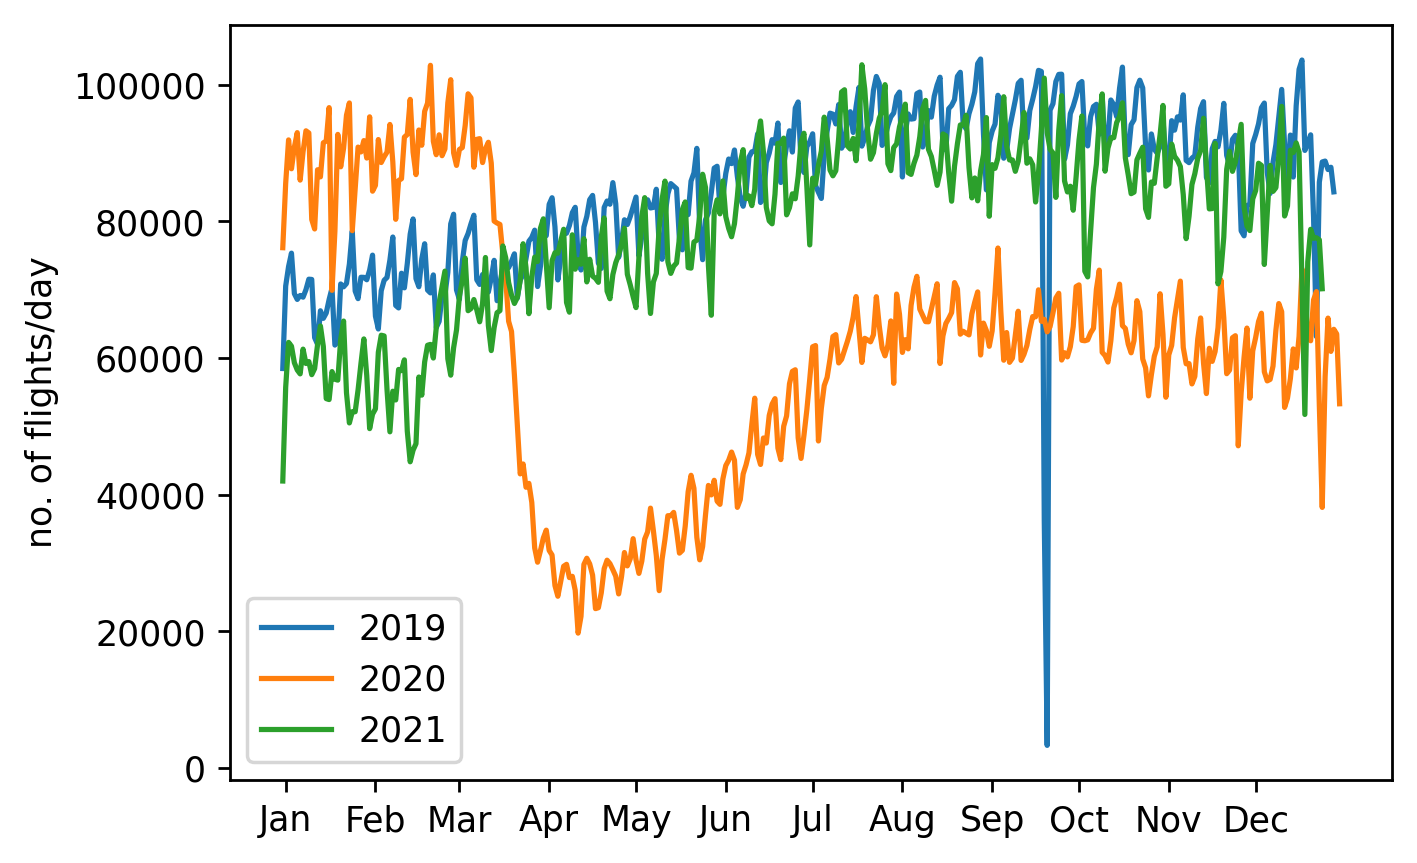

CPU times: user 1min 35s, sys: 12.9 s, total: 1min 47s
Wall time: 1min 47s


In [7]:
%%time
num_flights=[]

for y in year:
    df = load_cudf(y)
    num_flights.append(flights_per_day_df(df))
    del df

fig, ax = plt.subplots()
for i,data in enumerate(num_flights):
    ax.plot(data, label=year[i])
#ax.plot(num2020, label='2020')
#ax.plot(num2021, label='2021')
month_starts = [1,32,61,92,122,153,183,214,245,275,306,336]
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec'] 

ax.set_xticks(month_starts)
ax.set_xticklabels(month_names)
plt.legend()
plt.ylabel('no. of flights/day')
plt.show()

### What is the distance for each flight?

This is an array operations to substract, sum, square element-wise.

In [30]:
def flight_distance(df):
    df.latitude_1.dropna()
    df.longitude_1.dropna()
    df.latitude_2.dropna()
    df.longitude_2.dropna()

    df = df.drop_duplicates(subset=['callsign'])
    
    lat = df['latitude_1']-df['latitude_2']
    lon = df['longitude_1']-df['longitude_2']
    dist = np.sqrt(lat**2+lon**2)
    return dist

In [31]:
%%time
#1. Pandas dataframe
pd_dist = flight_distance(pd2019)

CPU times: user 7.03 s, sys: 1.37 s, total: 8.39 s
Wall time: 8.39 s


In [32]:
%%time
#2. cuDF dataframe
cu_dist = flight_distance(cudf2019)

CPU times: user 835 ms, sys: 59.5 ms, total: 895 ms
Wall time: 900 ms


# Summary of the Benchmarks

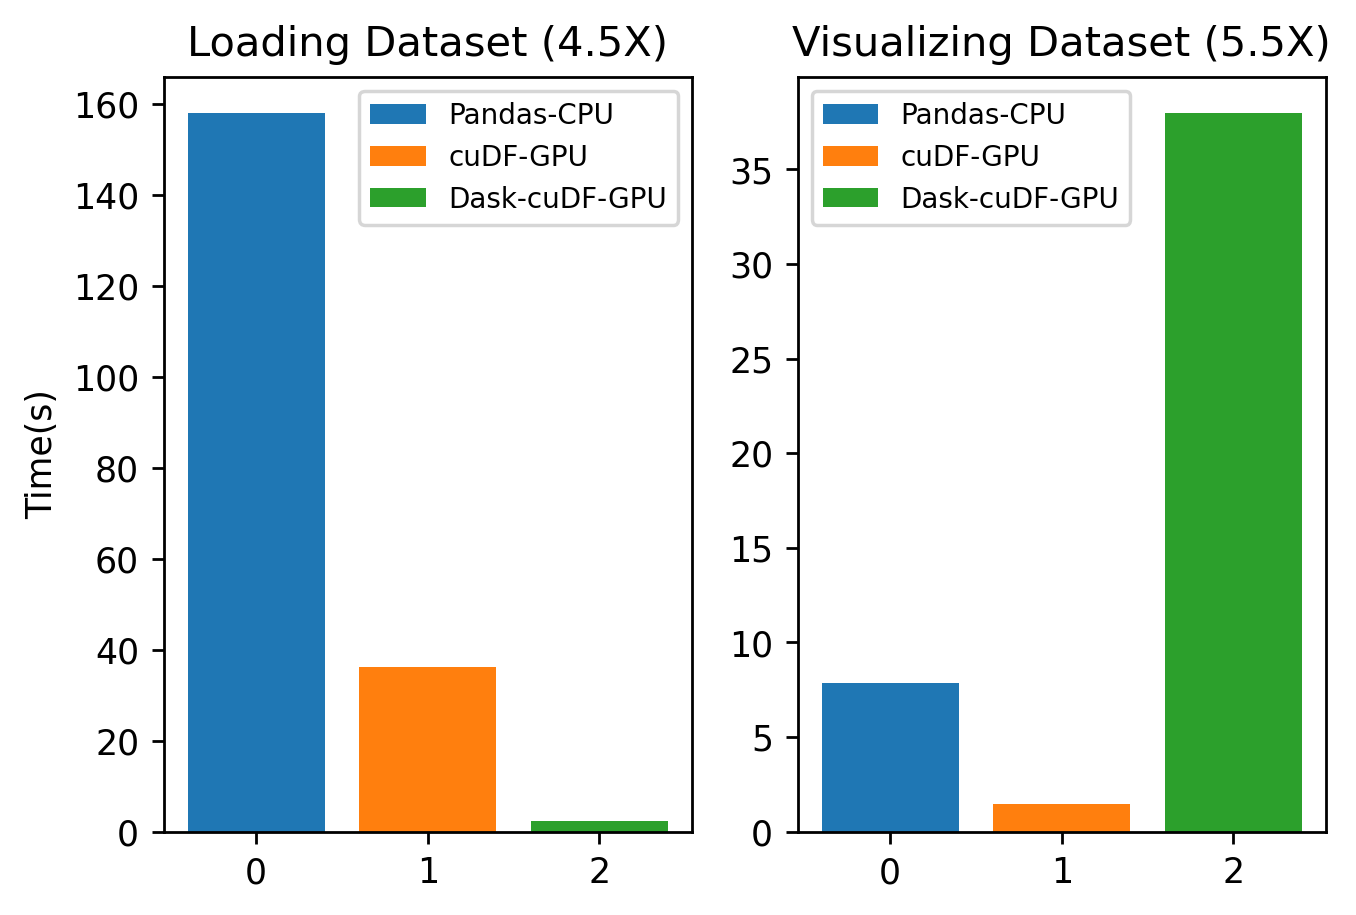

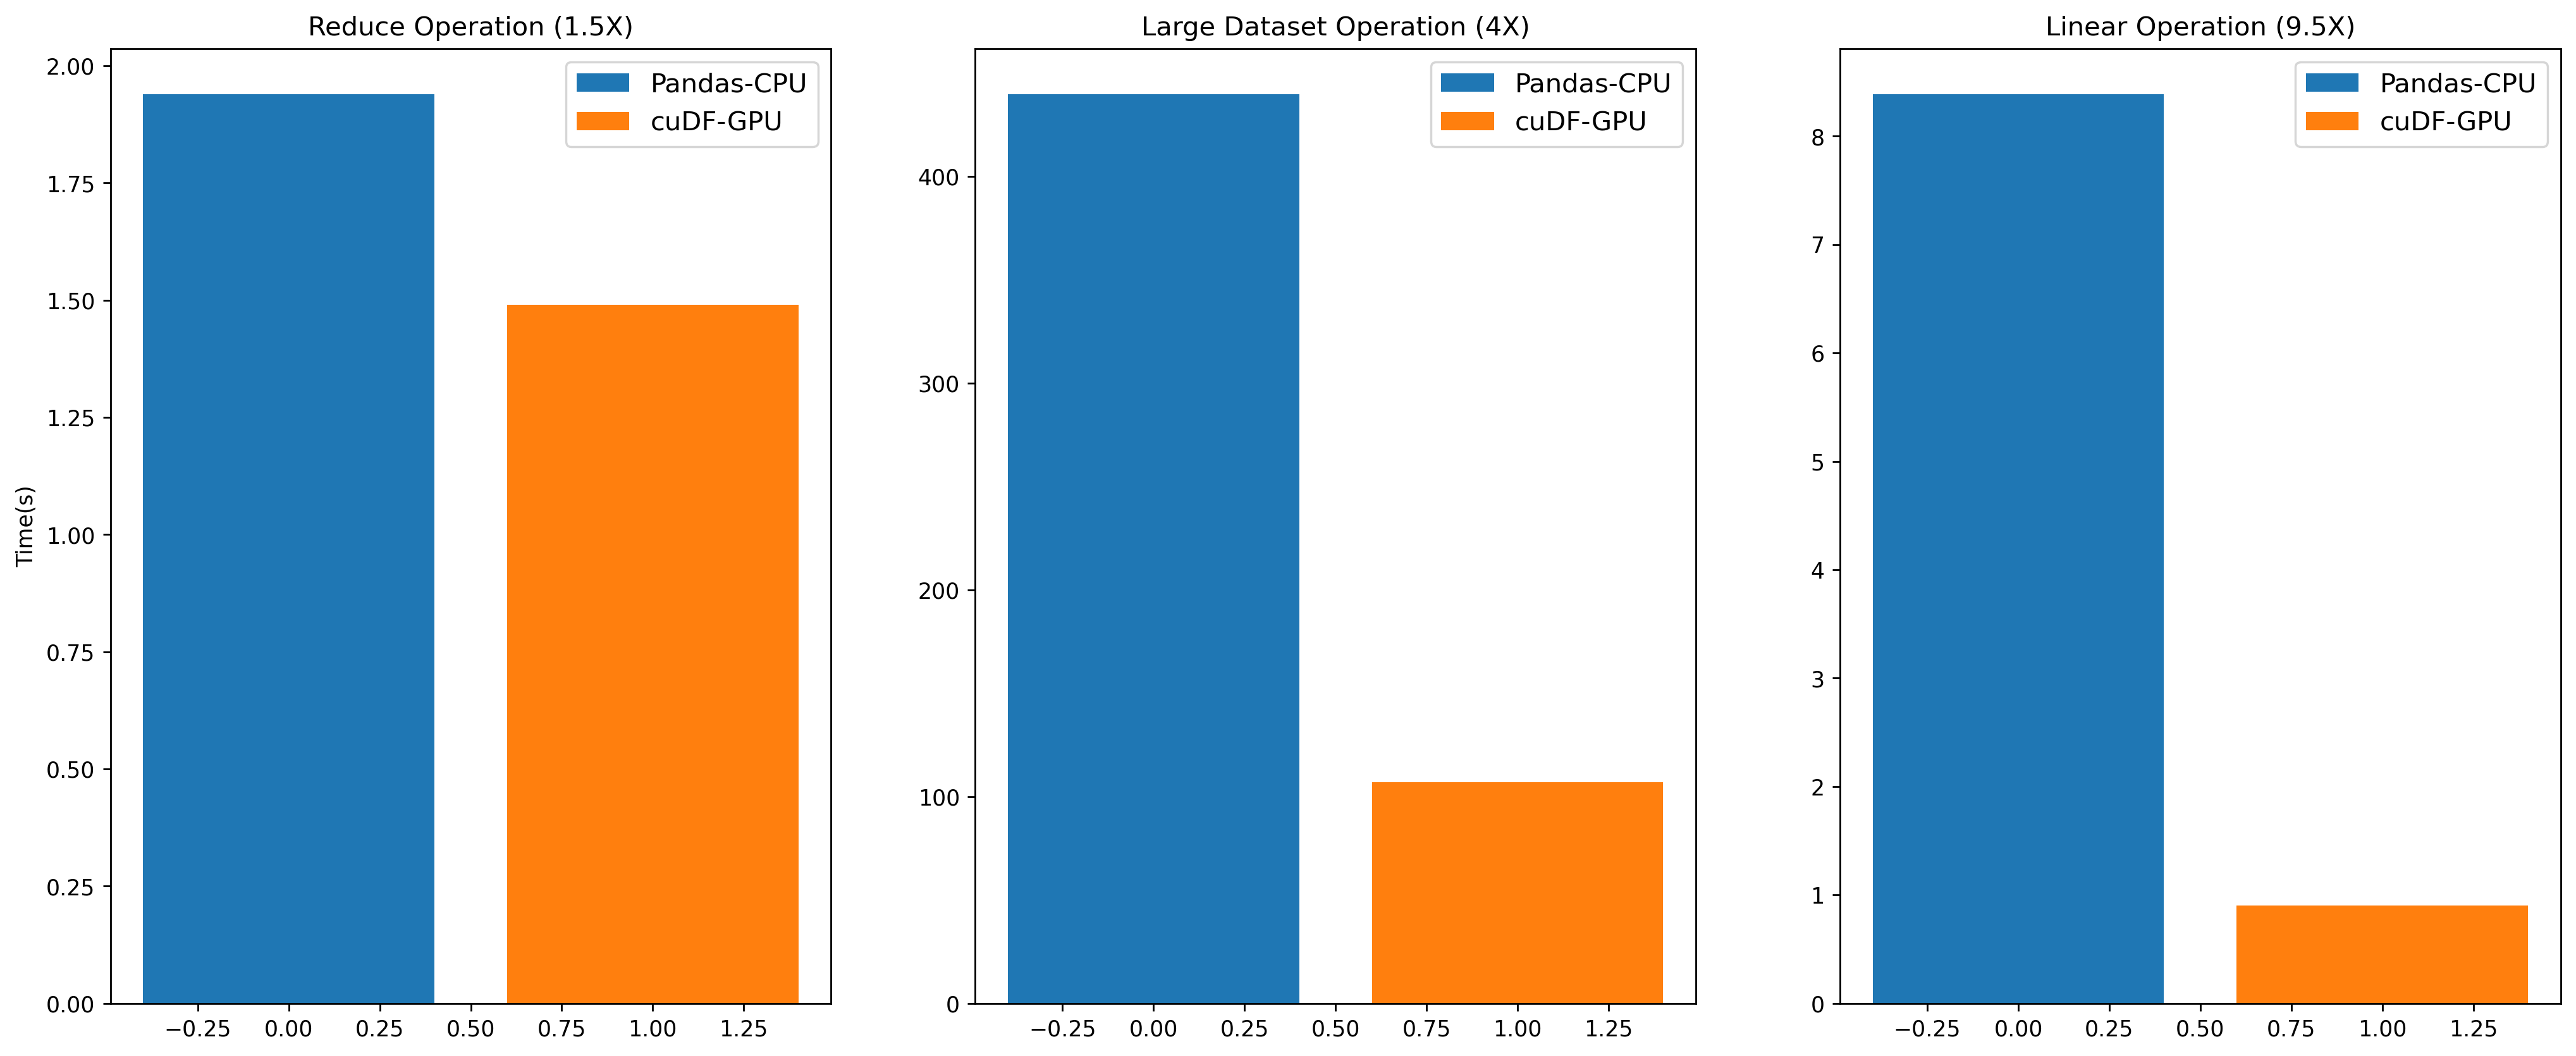

In [46]:
#benchmarks in time
load_data = [158, 36.2, 2.43]
vis_data = [7.88, 1.44, 38]
reduce_data = [1.94, 1.49]
large_data = [440, 107]
linear_data = [8.39, 0.9]

labels = ['Pandas-CPU', 'cuDF-GPU', 'Dask-cuDF-GPU']

f, (ax1, ax2) = plt.subplots(1, 2)
for i in range(3):
    ax1.bar(i,load_data[i], label=labels[i])
    ax2.bar(i,vis_data[i], label=labels[i])
ax1.set_title(r'Loading Dataset (4.5X)')
ax2.set_title('Visualizing Dataset (5.5X)')
ax1.set_ylabel('Time(s)')
ax1.legend(fontsize=8)
ax2.legend(fontsize=8)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))
for i in range(2):
    ax1.bar(i,reduce_data[i], label=labels[i])
    ax2.bar(i,large_data[i], label=labels[i])
    ax3.bar(i,linear_data[i], label=labels[i])
ax1.set_title('Reduce Operation (1.5X)')
ax2.set_title('Large Dataset Operation (4X)')
ax3.set_title('Linear Operation (9.5X)')
ax1.set_ylabel('Time(s)')
ax1.legend(fontsize=12)
ax2.legend(fontsize=12)
ax3.legend(fontsize=12)
